In [5]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import datetime 
import gmaps
import sys
sys.path.insert(1, '/ignore/api_key')
from api_key import api_key
from pylab import *

In [6]:
#Load in csv 
df = pd.read_csv("analyze_me.csv")

In [312]:
#Check for non-null counts, clearly there are many null values in the item_name, item_quantity, and item_catgeory_name columns. 
#Dtypes for the timestamps are incorrect, need to be reformatted to datetime objects. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5983 entries, 0 to 5982
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   delivery_id                          5983 non-null   int64  
 1   customer_id                          5983 non-null   int64  
 2   jumpman_id                           5983 non-null   int64  
 3   vehicle_type                         5983 non-null   object 
 4   pickup_place                         5983 non-null   object 
 5   place_category                       5100 non-null   object 
 6   item_name                            4753 non-null   object 
 7   item_quantity                        4753 non-null   float64
 8   item_category_name                   4753 non-null   object 
 9   how_long_it_took_to_order            3038 non-null   object 
 10  pickup_lat                           5983 non-null   float64
 11  pickup_lon                    

In [313]:
#Count of all NaN in each column 
null = df.isnull().sum()
#Count all non null values 
notnull = df.count(axis=0)
#% of data that is null by column 
pct_null = (null/(null+notnull))*100
print(pct_null)
#20.5% of item name and category names are not collected. If these categories were captured targeted ad campaigns could be made to drive new user acquisition 

delivery_id                             0.000000
customer_id                             0.000000
jumpman_id                              0.000000
vehicle_type                            0.000000
pickup_place                            0.000000
place_category                         14.758482
item_name                              20.558248
item_quantity                          20.558248
item_category_name                     20.558248
how_long_it_took_to_order              49.222798
pickup_lat                              0.000000
pickup_lon                              0.000000
dropoff_lat                             0.000000
dropoff_lon                             0.000000
when_the_delivery_started               0.000000
when_the_Jumpman_arrived_at_pickup      9.192713
when_the_Jumpman_left_pickup            9.192713
when_the_Jumpman_arrived_at_dropoff     0.000000
dtype: float64


In [327]:
#There are duplicate values for each delivery_id which would affect the analysis downstream, these duplicate rows must be expunged before proceeding with analysis. 
df.nunique()

delivery_id                            5214
customer_id                            3192
jumpman_id                              578
vehicle_type                              7
pickup_place                            898
place_category                           57
item_name                              2277
item_quantity                            11
item_category_name                      767
how_long_it_took_to_order              2579
pickup_lat                             1210
pickup_lon                             1179
dropoff_lat                            2841
dropoff_lon                            2839
when_the_delivery_started              5214
when_the_Jumpman_arrived_at_pickup     4719
when_the_Jumpman_left_pickup           4717
when_the_Jumpman_arrived_at_dropoff    5214
dtype: int64

In [320]:
ID = df["delivery_id"]

In [322]:
pd.concat(g for _, g in df.groupby("delivery_id") if len(g) > 1)

,delivery_id,customer_id,jumpman_id,vehicle_type,pickup_place,place_category,item_name,item_quantity,item_category_name,how_long_it_took_to_order,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,when_the_delivery_started,when_the_Jumpman_arrived_at_pickup,when_the_Jumpman_left_pickup,when_the_Jumpman_arrived_at_dropoff
1008,1272701,81085,112646,bicycle,Mighty Quinn's BBQ,BBQ,Brisket,1.0,Meats,NaN,40.727519,-73.988671,40.723962,-73.993393,2014-10-01 12:12:24.393054,2014-10-01 12:17:22.929789,2014-10-01 12:27:42.369732,2014-10-01 12:34:27.142996
5080,1272701,81085,112646,bicycle,Mighty Quinn's BBQ,BBQ,Housemade Iced Tea,1.0,Beverages,NaN,40.727519,-73.988671,40.723962,-73.993393,2014-10-01 12:12:24.393054,2014-10-01 12:17:22.929789,2014-10-01 12:27:42.369732,2014-10-01 12:34:27.142996
2272,1274248,208020,60149,car,Murray's Falafel,Middle Eastern,Blue Lamoon Citrus blossom lemonade w/ Splenda,1.0,Beverages,00:07:08.767432,40.732166,-73.981904,40.747019,-73.990922,2014-10-01 17:25:48.54633,2014-10-01 17:40:32.886964,2014-10-01 17:53:54.166799,2014-10-01 18:09:37.353403
2299,1274248,208020,60149,car,Murray's Falafel,Middle Eastern,Moroccan Cigars (5 pc),1.0,Appetizers,00:07:08.767432,40.732166,-73.981904,40.747019,-73.990922,2014-10-01 17:25:48.54633,2014-10-01 17:40:32.886964,2014-10-01 17:53:54.166799,2014-10-01 18:09:37.353403
2986,1274248,208020,60149,car,Murray's Falafel,Middle Eastern,Watermelon,1.0,Desserts,00:07:08.767432,40.732166,-73.981904,40.747019,-73.990922,2014-10-01 17:25:48.54633,2014-10-01 17:40:32.886964,2014-10-01 17:53:54.166799,2014-10-01 18:09:37.353403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3020,1490744,52256,38597,bicycle,Han Dynasty,Chinese,Wonton in Chicken Broth,1.0,Soups,00:09:51.159698,40.732213,-73.988072,40.732288,-73.987752,2014-10-30 21:44:05.205404,2014-10-30 21:51:58.394867,2014-10-30 22:06:52.148926,2014-10-30 22:08:06.563304
4074,1490744,52256,38597,bicycle,Han Dynasty,Chinese,Bok Choy with Black Mushrooms,1.0,Vegetables,00:09:51.159698,40.732213,-73.988072,40.732288,-73.987752,2014-10-30 21:44:05.205404,2014-10-30 21:51:58.394867,2014-10-30 22:06:52.148926,2014-10-30 22:08:06.563304
4983,1490744,52256,38597,bicycle,Han Dynasty,Chinese,Dan Dan Noodle,1.0,Noodles,00:09:51.159698,40.732213,-73.988072,40.732288,-73.987752,2014-10-30 21:44:05.205404,2014-10-30 21:51:58.394867,2014-10-30 22:06:52.148926,2014-10-30 22:08:06.563304
1315,1491424,391367,172130,walker,Veselka,Russian,Small Plate of Pierogis,1.0,Handmade Varenyky (Pierogi),00:07:29.766955,40.729136,-73.986972,40.723531,-73.982324,2014-10-30 23:08:43.4819,2014-10-30 23:10:31.062088,2014-10-30 23:23:51.143279,2014-10-30 23:29:44.866438


In [323]:
#There are duplicate rows made when multiple items are ordered from a single pickup_place, these duplicate rows should be purged before further analysis 
df.loc[df['delivery_id'] == 1274248]

,delivery_id,customer_id,jumpman_id,vehicle_type,pickup_place,place_category,item_name,item_quantity,item_category_name,how_long_it_took_to_order,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,when_the_delivery_started,when_the_Jumpman_arrived_at_pickup,when_the_Jumpman_left_pickup,when_the_Jumpman_arrived_at_dropoff
2272,1274248,208020,60149,car,Murray's Falafel,Middle Eastern,Blue Lamoon Citrus blossom lemonade w/ Splenda,1.0,Beverages,00:07:08.767432,40.732166,-73.981904,40.747019,-73.990922,2014-10-01 17:25:48.54633,2014-10-01 17:40:32.886964,2014-10-01 17:53:54.166799,2014-10-01 18:09:37.353403
2299,1274248,208020,60149,car,Murray's Falafel,Middle Eastern,Moroccan Cigars (5 pc),1.0,Appetizers,00:07:08.767432,40.732166,-73.981904,40.747019,-73.990922,2014-10-01 17:25:48.54633,2014-10-01 17:40:32.886964,2014-10-01 17:53:54.166799,2014-10-01 18:09:37.353403
2986,1274248,208020,60149,car,Murray's Falafel,Middle Eastern,Watermelon,1.0,Desserts,00:07:08.767432,40.732166,-73.981904,40.747019,-73.990922,2014-10-01 17:25:48.54633,2014-10-01 17:40:32.886964,2014-10-01 17:53:54.166799,2014-10-01 18:09:37.353403


In [7]:
#Drop duplicates on delivery_id, ensure that new length of dataframe is equal to number of unique delivery_id's before cleaning the dataframe
new_df = df.drop_duplicates(subset="delivery_id")
if len(new_df) == df["delivery_id"].nunique():
    print("dataframe clean")

dataframe clean


In [328]:
new_df.head(1)

,delivery_id,customer_id,jumpman_id,vehicle_type,pickup_place,place_category,item_name,item_quantity,item_category_name,how_long_it_took_to_order,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,when_the_delivery_started,when_the_Jumpman_arrived_at_pickup,when_the_Jumpman_left_pickup,when_the_Jumpman_arrived_at_dropoff
0,1457973,327168,162381,van,Melt Shop,American,Lemonade,1.0,Beverages,00:19:58.582052,40.744607,-73.990742,40.752073,-73.98537,2014-10-26 13:51:59.898924,NaN,NaN,2014-10-26 14:52:06.313088


In [8]:
#reformat Dtypes so that units of time are saved as datetime objects rather than objects 
new_df["how_long_it_took_to_order"] = pd.to_timedelta(new_df["how_long_it_took_to_order"])
new_df["when_the_delivery_started"] = pd.to_datetime(new_df["when_the_delivery_started"])
new_df["when_the_Jumpman_arrived_at_pickup"] = pd.to_datetime(new_df["when_the_Jumpman_arrived_at_pickup"])
new_df["when_the_Jumpman_left_pickup"] = pd.to_datetime(new_df["when_the_Jumpman_left_pickup"])
new_df["when_the_Jumpman_arrived_at_dropoff"] = pd.to_datetime(new_df["when_the_Jumpman_arrived_at_dropoff"])

In [9]:
#convert timedelta object to minutes 
new_df["how_long_it_took_to_order"] = new_df["how_long_it_took_to_order"] / np.timedelta64(1, 'm')

In [10]:
#Create column for prep time 
new_df["prep_time"] = new_df["when_the_Jumpman_left_pickup"] - new_df["when_the_Jumpman_arrived_at_pickup"]
#Convert time to minutes
new_df["prep_time"] = new_df["prep_time"] / np.timedelta64(1, 'm')
#Create column for transit time 
new_df["transit_time"] = new_df["when_the_Jumpman_arrived_at_dropoff"] - new_df["when_the_Jumpman_left_pickup"]
#convert time to minutes
new_df["transit_time"] = new_df["transit_time"] / np.timedelta64(1, 'm')
#Create Column for Total order time 
new_df["total_order_time"] = new_df["when_the_Jumpman_arrived_at_dropoff"] - new_df["when_the_delivery_started"]
#convert time to minutes
new_df["total_order_time"] = new_df["total_order_time"] / np.timedelta64(1, 'm')

In [410]:
new_df.columns

Index(['delivery_id', 'customer_id', 'jumpman_id', 'vehicle_type',
       'pickup_place', 'place_category', 'item_name', 'item_quantity',
       'item_category_name', 'how_long_it_took_to_order', 'pickup_lat',
       'pickup_lon', 'dropoff_lat', 'dropoff_lon', 'when_the_delivery_started',
       'when_the_Jumpman_arrived_at_pickup', 'when_the_Jumpman_left_pickup',
       'when_the_Jumpman_arrived_at_dropoff', 'prep_time', 'transit_time',
       'total_order_time', 'distance_miles'],
      dtype='object')

In [11]:
#Create boxplot of time to order, first keep only values that are not null. 
order_length_df = new_df[new_df["how_long_it_took_to_order"].notna()]

Text(0.5, 1.0, 'Latency to Order Placement')

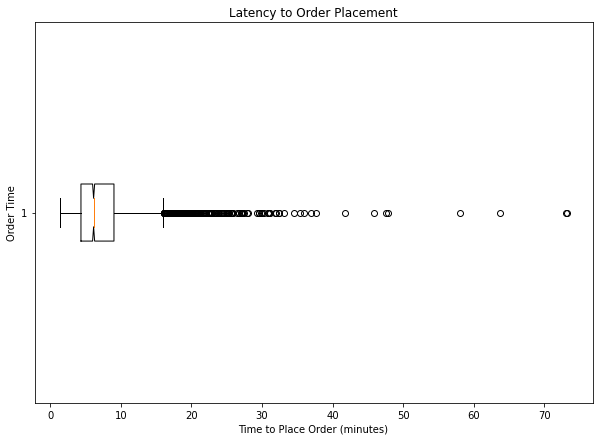

In [12]:
#Create boxplot of time to order 
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)

bp = ax.boxplot(order_length_df["how_long_it_took_to_order"], notch=True, vert=False)
ax.set_xlabel("Time to Place Order (minutes)")
ax.set_ylabel("Order Time")
plt.title("Latency to Order Placement")

In [13]:
#boxplot of prep time, transit time, and total time
prep_time_df = new_df[new_df["prep_time"].notna()]
transit_time_df = new_df[new_df["transit_time"].notna()]
total_order_df = new_df[new_df["total_order_time"].notna()]

Text(0.5, 1.0, 'Prep Time, Transit Time, and Total Order Time in Minutes')

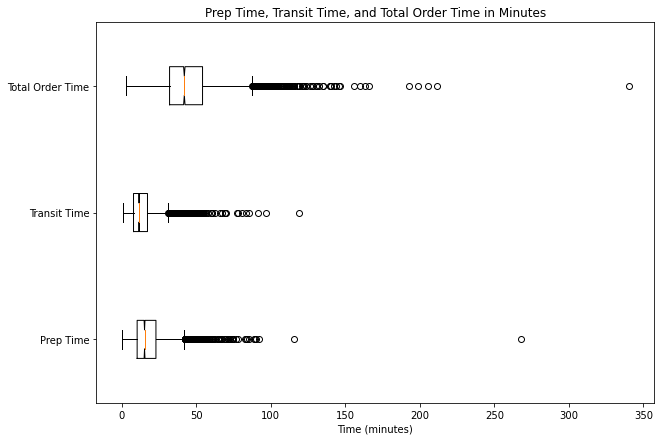

In [14]:
#Create boxplot of prep time, transit time, and total time
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)

bp = ax.boxplot([prep_time_df["prep_time"], transit_time_df["transit_time"], total_order_df["total_order_time"]], notch=True, vert=False)
ax.set_yticklabels(["Prep Time", "Transit Time", "Total Order Time"])
ax.set_xlabel("Time (minutes)")
plt.title("Prep Time, Transit Time, and Total Order Time in Minutes")

In [15]:
#Determine the type of vehicle used for delivery 
vehicle_type = {
    "Type" : ["Bicycle", "Car", "Truck", "Scooter", "Walker", "Van", "Motorcycle"],
    "Count" : [new_df[new_df["vehicle_type"] == "bicycle"].shape[0], new_df[new_df["vehicle_type"] == "car"].shape[0], new_df[new_df["vehicle_type"] == "truck"].shape[0], new_df[new_df["vehicle_type"] == "scooter"].shape[0], new_df[new_df["vehicle_type"] == "walker"].shape[0], new_df[new_df["vehicle_type"] == "van"].shape[0], new_df[new_df["vehicle_type"] == "motorcycle"].shape[0]]
}

Text(0.5, 1.0, 'Delivery Vehicle Types')

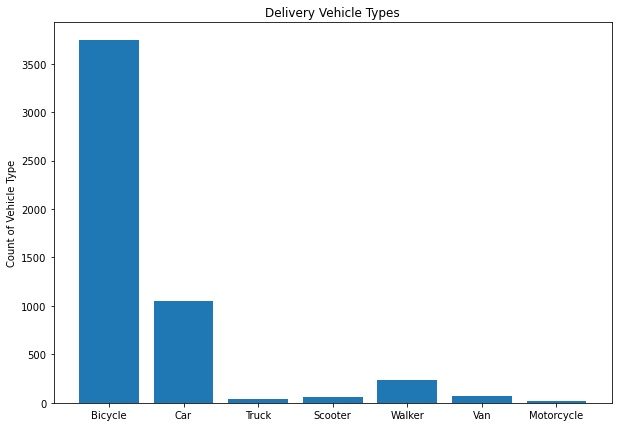

In [16]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)

bar = ax.bar(x=vehicle_type["Type"], height=vehicle_type["Count"])
ax.set_ylabel("Count of Vehicle Type")
plt.title("Delivery Vehicle Types")

In [17]:
#Determine distance traveled between pickup and dropoff, this returns distance traveled in miles
def haversine_distance(lat1, lon1, lat2, lon2):
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 2)*0.62137

In [18]:
#compute distance traveled in miles using haversine distance formula, round to 4 decimal places 
new_df["distance_miles"] = round(haversine_distance(new_df["pickup_lat"], new_df["pickup_lon"], new_df["dropoff_lat"], new_df["dropoff_lon"]),4)

In [19]:
#Retrieve distance traveled by each vehicle type 
bicycle = new_df.loc[new_df["vehicle_type"] == "bicycle"]
bicycle_distance = bicycle["distance_miles"].tolist()
car = new_df.loc[new_df["vehicle_type"] == "car"]
car_distance = car["distance_miles"].tolist()
truck = new_df.loc[new_df["vehicle_type"] == 'truck']
truck_distance = truck["distance_miles"].tolist()
scooter = new_df.loc[new_df["vehicle_type"] == 'scooter']
scooter_distance = scooter["distance_miles"].tolist()
walker = new_df.loc[new_df['vehicle_type'] == "walker"]
walker_distance = walker["distance_miles"].tolist()
van = new_df.loc[new_df["vehicle_type"] == 'van']
van_distance = van["distance_miles"].tolist()
motorcycle = new_df.loc[new_df["vehicle_type"]=='motorcycle']
motorcycle_distance = motorcycle["distance_miles"].tolist()
data = [bicycle_distance, car_distance, truck_distance, scooter_distance, walker_distance, van_distance, motorcycle_distance]

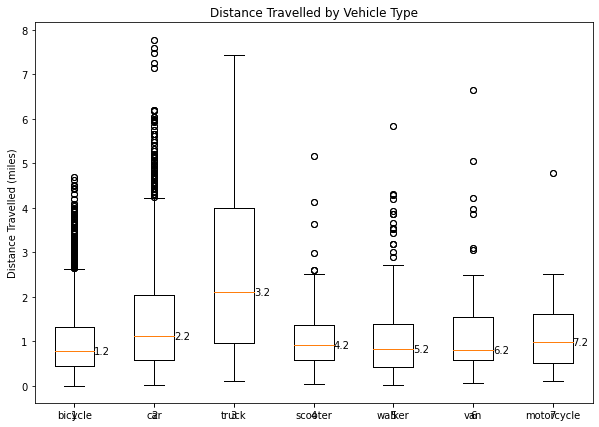

In [20]:
#boxplot of distance travelled by vehicle type 
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)

bp = ax.boxplot(data)
ax.set_ylabel("Distance Travelled (miles)")
ax.set_xticklabels(["bicycle", "car", "truck", "scooter", "walker", "van", "motorcycle"])
plt.title("Distance Travelled by Vehicle Type")

vtdist_bpdict = boxplot(data)

for line in vtdist_bpdict['medians']:
    x, y = line.get_xydata()[1]
    text(x, y, '%.1f' % x, 
        verticalalignment='center')

In [21]:
#Find top ten pickup restaurants 
top_ten = pd.DataFrame(new_df["pickup_place"].value_counts().head(10))
top_ten_names = top_ten.index.tolist()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

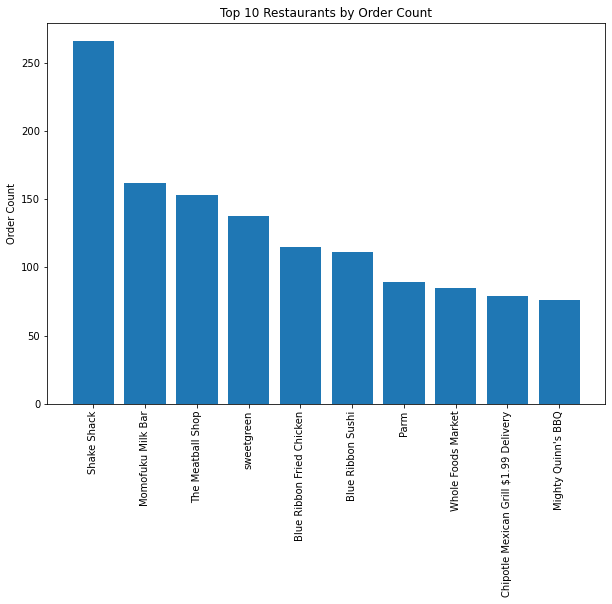

In [22]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)

bar = ax.bar(x=top_ten_names, height=top_ten["pickup_place"])
ax.set_ylabel("Order Count")
plt.title("Top 10 Restaurants by Order Count")
plt.xticks(rotation=90)

In [23]:
avg_dropoff_latency_dict = {
    "Name" : top_ten_names
}
avg_dropoff_latency = []

In [24]:
for name in top_ten_names:
    temp = new_df.loc[new_df["pickup_place"] == name]["total_order_time"].mean()
    avg_dropoff_latency.append(temp)
avg_dropoff_latency_dict["time"] = avg_dropoff_latency

Text(0.5, 1.0, 'Fulfillment Time for Top Ten Restaurants')

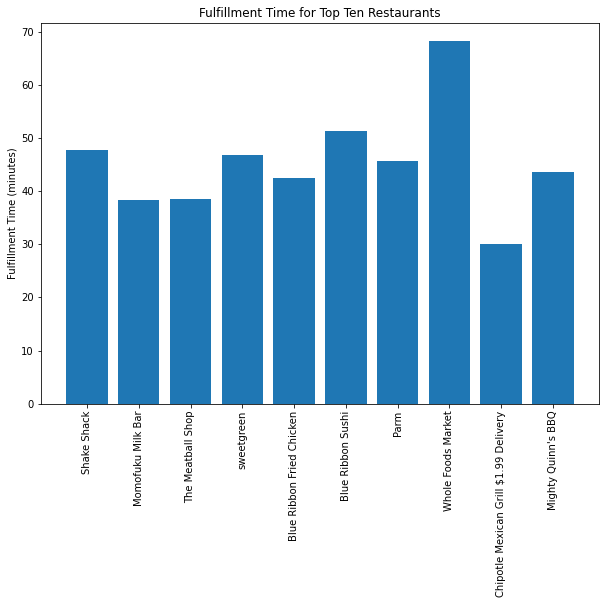

In [25]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)

brp = ax.bar(x=avg_dropoff_latency_dict["Name"], height=avg_dropoff_latency_dict["time"])
plt.xticks(rotation=90)
plt.ylabel("Fulfillment Time (minutes)")
plt.title("Fulfillment Time for Top Ten Restaurants")

In [26]:
#Order volumes based on time 
new_df["day"] = new_df["when_the_delivery_started"].dt.day
new_df["hour"] = new_df["when_the_delivery_started"].dt.hour
new_df["weekdate"] = new_df["when_the_delivery_started"].dt.dayofweek
new_df["week"] = new_df["when_the_delivery_started"].dt.week

In [43]:
#Delivery counts by hour 
hhcounts = new_df.groupby(['day', 'hour'])['delivery_id'].count().groupby('hour').sum().tolist()

In [44]:
print(hhcounts)

[64, 31, 22, 7, 5, 2, 19, 27, 84, 149, 287, 367, 282, 238, 231, 251, 376, 644, 795, 626, 396, 192, 119]


In [45]:
hhcounts.append(0)

In [46]:
x = [i for i in range(24)]

Text(0, 0.5, 'Count of Orders')

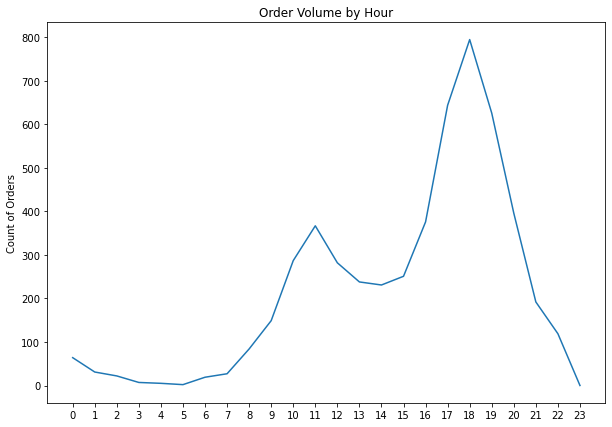

In [50]:
fig = plt.figure(figsize=(10,7))
plt.plot(x, hhcounts)
plt.xticks(range(24))
plt.title("Order Volume by Hour")
plt.ylabel("Count of Orders")

In [456]:
x = [1, 2]
y = [1, 2]

In [200]:
nyc_coords = (40.7128, -74.0060)

In [202]:
gmaps.configure(api_key=api_key)

In [93]:
#load in csv 
df = pd.read_csv("analyze_me.csv")

In [310]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5983 entries, 0 to 5982
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   delivery_id                          5983 non-null   int64  
 1   customer_id                          5983 non-null   int64  
 2   jumpman_id                           5983 non-null   int64  
 3   vehicle_type                         5983 non-null   object 
 4   pickup_place                         5983 non-null   object 
 5   place_category                       5100 non-null   object 
 6   item_name                            4753 non-null   object 
 7   item_quantity                        4753 non-null   float64
 8   item_category_name                   4753 non-null   object 
 9   how_long_it_took_to_order            3038 non-null   object 
 10  pickup_lat                           5983 non-null   float64
 11  pickup_lon                    

In [94]:
df.head(10)

,delivery_id,customer_id,jumpman_id,vehicle_type,pickup_place,place_category,item_name,item_quantity,item_category_name,how_long_it_took_to_order,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,when_the_delivery_started,when_the_Jumpman_arrived_at_pickup,when_the_Jumpman_left_pickup,when_the_Jumpman_arrived_at_dropoff
0,1457973,327168,162381,van,Melt Shop,American,Lemonade,1.0,Beverages,00:19:58.582052,40.744607,-73.990742,40.752073,-73.985370,2014-10-26 13:51:59.898924,NaN,NaN,2014-10-26 14:52:06.313088
1,1377056,64452,104533,bicycle,Prince Street Pizza,Pizza,Neapolitan Rice Balls,3.0,Munchables,00:25:09.107093,40.723080,-73.994615,40.719722,-73.991858,2014-10-16 21:58:58.65491,2014-10-16 22:26:02.120931,2014-10-16 22:48:23.091253,2014-10-16 22:59:22.948873
2,1476547,83095,132725,bicycle,Bareburger,Burger,Bare Sodas,1.0,Drinks,00:06:44.541717,40.728478,-73.998392,40.728606,-73.995143,2014-10-28 21:39:52.654394,2014-10-28 21:37:18.793405,2014-10-28 21:59:09.98481,2014-10-28 22:04:40.634962
3,1485494,271149,157175,bicycle,Juice Press,Juice Bar,OMG! My Favorite Juice!,1.0,Cold Pressed Juices,NaN,40.738868,-74.002747,40.751257,-74.005634,2014-10-30 10:54:11.531894,2014-10-30 11:04:17.759577,2014-10-30 11:16:37.895816,2014-10-30 11:32:38.090061
4,1327707,122609,118095,bicycle,Blue Ribbon Sushi,Japanese,Spicy Tuna & Tempura Flakes,2.0,Maki (Special Rolls),00:03:45.035418,40.726110,-74.002492,40.709323,-74.015867,2014-10-10 00:07:18.450505,2014-10-10 00:14:42.702223,2014-10-10 00:25:19.400294,2014-10-10 00:48:27.150595
5,1423142,75169,91932,bicycle,Tamarind TriBeCa,Indian,Dum Aloo Gobi,1.0,Vegetarian Specialties,00:07:14.327405,40.719269,-74.008750,40.725678,-74.000618,2014-10-22 18:56:36.348939,2014-10-22 19:18:49.953427,2014-10-22 19:27:10.57897,2014-10-22 19:36:53.801191
6,1334106,101347,124897,bicycle,The Loop,Sushi,Spicy Tuna Roll,1.0,Classic Roll & Hand Roll,00:04:49.413655,40.734858,-73.986093,40.738368,-74.000105,2014-10-10 21:08:55.489926,2014-10-10 21:07:15.966292,2014-10-10 21:29:24.500711,2014-10-10 21:40:01.697548
7,1311619,59161,79847,bicycle,Insomnia Cookies,Bakery,Chocolate Chunk,2.0,Cookies and Brownies,NaN,40.729791,-74.000589,40.734703,-73.998206,2014-10-06 23:20:09.312584,2014-10-06 23:17:35.66695,2014-10-07 00:03:24.389592,2014-10-07 00:09:16.559521
8,1487674,55375,181543,bicycle,Cafe Zaiya,NaN,NaN,NaN,NaN,NaN,40.729357,-73.990156,40.719758,-73.985011,2014-10-30 16:49:48.259935,2014-10-30 16:55:32.446053,2014-10-30 17:01:22.214264,2014-10-30 17:10:44.731901
9,1417206,153816,157415,car,Shake Shack,Burger,Shackburger,1.0,Burgers,NaN,40.758457,-73.989140,40.743613,-73.977684,2014-10-21 21:18:37.909545,2014-10-21 21:20:14.434227,2014-10-21 21:47:03.624931,2014-10-21 21:59:26.081278


In [59]:
clean_df = df.dropna()

In [62]:
clean_df.head(5)

,delivery_id,customer_id,jumpman_id,vehicle_type,pickup_place,place_category,item_name,item_quantity,item_category_name,how_long_it_took_to_order,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,when_the_delivery_started,when_the_Jumpman_arrived_at_pickup,when_the_Jumpman_left_pickup,when_the_Jumpman_arrived_at_dropoff
1,1377056,64452,104533,bicycle,Prince Street Pizza,Pizza,Neapolitan Rice Balls,3.0,Munchables,00:25:09,40.723080,-73.994615,40.719722,-73.991858,2014-10-16 21:58:58.65491,2014-10-16 22:26:02.120931,2014-10-16 22:48:23.091253,2014-10-16 22:59:22.948873
2,1476547,83095,132725,bicycle,Bareburger,Burger,Bare Sodas,1.0,Drinks,00:06:44,40.728478,-73.998392,40.728606,-73.995143,2014-10-28 21:39:52.654394,2014-10-28 21:37:18.793405,2014-10-28 21:59:09.98481,2014-10-28 22:04:40.634962
4,1327707,122609,118095,bicycle,Blue Ribbon Sushi,Japanese,Spicy Tuna & Tempura Flakes,2.0,Maki (Special Rolls),00:03:45,40.726110,-74.002492,40.709323,-74.015867,2014-10-10 00:07:18.450505,2014-10-10 00:14:42.702223,2014-10-10 00:25:19.400294,2014-10-10 00:48:27.150595
5,1423142,75169,91932,bicycle,Tamarind TriBeCa,Indian,Dum Aloo Gobi,1.0,Vegetarian Specialties,00:07:14,40.719269,-74.008750,40.725678,-74.000618,2014-10-22 18:56:36.348939,2014-10-22 19:18:49.953427,2014-10-22 19:27:10.57897,2014-10-22 19:36:53.801191
6,1334106,101347,124897,bicycle,The Loop,Sushi,Spicy Tuna Roll,1.0,Classic Roll & Hand Roll,00:04:49,40.734858,-73.986093,40.738368,-74.000105,2014-10-10 21:08:55.489926,2014-10-10 21:07:15.966292,2014-10-10 21:29:24.500711,2014-10-10 21:40:01.697548


In [50]:
backup_df = clean_df 

In [55]:
clean_df = backup_df

In [61]:
#split the time it took to order on the decimal to convert to seconds. 
clean_df["how_long_it_took_to_order"] = clean_df["how_long_it_took_to_order"].str.split(pat='.', expand=True)

In [68]:
#split when delivery started 
clean_df[["delivery_start_date", "when_delivery_started"]] = clean_df["when_the_delivery_started"].str.split(expand=True)

In [70]:
#split the time delivery started on decimal to convert to seconds 
clean_df["when_delivery_started"] = clean_df["when_delivery_started"].str.split(pat='.', expand=True)

In [76]:
#split the Jumpman arrival time 
clean_df[["dropoff_date", "when_Jumpman_arrived_dropoff"]] = clean_df["when_the_Jumpman_arrived_at_dropoff"].str.split(expand=True)

In [78]:
#split time Jumpman arrived at dropoff on decimal to convert to seconds
clean_df["when_Jumpman_arrived_dropoff"] = clean_df["when_Jumpman_arrived_dropoff"].str.split(pat='.', expand=True)

In [79]:
clean_df

,delivery_id,customer_id,jumpman_id,vehicle_type,pickup_place,place_category,item_name,item_quantity,item_category_name,how_long_it_took_to_order,...,when_the_delivery_started,when_the_Jumpman_arrived_at_pickup,when_the_Jumpman_left_pickup,when_the_Jumpman_arrived_at_dropoff,order_time_seconds,delivery_start_date,when_delivery_started,delivery_started_time_seconds,dropoff_date,when_Jumpman_arrived_dropoff
1,1377056,64452,104533,bicycle,Prince Street Pizza,Pizza,Neapolitan Rice Balls,3.0,Munchables,00:25:09,...,2014-10-16 21:58:58.65491,2014-10-16 22:26:02.120931,2014-10-16 22:48:23.091253,2014-10-16 22:59:22.948873,1509,2014-10-16,21:58:58,79138,2014-10-16,22:59:22
2,1476547,83095,132725,bicycle,Bareburger,Burger,Bare Sodas,1.0,Drinks,00:06:44,...,2014-10-28 21:39:52.654394,2014-10-28 21:37:18.793405,2014-10-28 21:59:09.98481,2014-10-28 22:04:40.634962,404,2014-10-28,21:39:52,77992,2014-10-28,22:04:40
4,1327707,122609,118095,bicycle,Blue Ribbon Sushi,Japanese,Spicy Tuna & Tempura Flakes,2.0,Maki (Special Rolls),00:03:45,...,2014-10-10 00:07:18.450505,2014-10-10 00:14:42.702223,2014-10-10 00:25:19.400294,2014-10-10 00:48:27.150595,225,2014-10-10,00:07:18,438,2014-10-10,00:48:27
5,1423142,75169,91932,bicycle,Tamarind TriBeCa,Indian,Dum Aloo Gobi,1.0,Vegetarian Specialties,00:07:14,...,2014-10-22 18:56:36.348939,2014-10-22 19:18:49.953427,2014-10-22 19:27:10.57897,2014-10-22 19:36:53.801191,434,2014-10-22,18:56:36,68196,2014-10-22,19:36:53
6,1334106,101347,124897,bicycle,The Loop,Sushi,Spicy Tuna Roll,1.0,Classic Roll & Hand Roll,00:04:49,...,2014-10-10 21:08:55.489926,2014-10-10 21:07:15.966292,2014-10-10 21:29:24.500711,2014-10-10 21:40:01.697548,289,2014-10-10,21:08:55,76135,2014-10-10,21:40:01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5973,1379953,127103,69993,bicycle,The Grey Dog - University,Coffee,Organic Raw Veggies,1.0,Small Plates,00:04:34,...,2014-10-17 13:35:30.031409,2014-10-17 13:43:14.423209,2014-10-17 13:50:04.623095,2014-10-17 13:57:28.4103,274,2014-10-17,13:35:30,48930,2014-10-17,13:57:28
5975,1475459,303211,156557,car,Big Nick's Burgers & Pizza,Pizza,Chicken Fingers,1.0,Appetizers & Side Orders,00:05:11,...,2014-10-28 19:47:25.887723,2014-10-28 19:48:56.165939,2014-10-28 20:11:46.097208,2014-10-28 20:25:02.133169,311,2014-10-28,19:47:25,71245,2014-10-28,20:25:02
5977,1303444,228541,148268,bicycle,RedFarm Hudson,Chinese,Soft & Crunchy Vegetable Fried Rice,1.0,Rice & Noodles,00:03:32,...,2014-10-05 19:22:52.457615,2014-10-05 19:35:32.018316,2014-10-05 19:59:22.572157,2014-10-05 20:07:19.955589,212,2014-10-05,19:22:52,69772,2014-10-05,20:07:19
5981,1470282,400983,142140,car,Omai,Vietnamese,Ca Tim,1.0,Appetizers,00:02:17,...,2014-10-27 20:25:03.592287,2014-10-27 20:22:37.822461,2014-10-27 20:39:25.770399,2014-10-27 20:50:45.259345,137,2014-10-27,20:25:03,73503,2014-10-27,20:50:45


In [80]:
#Create a list of converted values to iterate over and convert to time in seconds. 
arrival_time = clean_df["when_Jumpman_arrived_dropoff"].tolist()

In [81]:
#iterate over and convert time to seconds
converted_time = []
for i in range(len(arrival_time)):
    hhmmss = arrival_time[i]
    [hours, minutes, seconds] = [int(x) for x in hhmmss.split(':')]
    x=datetime.timedelta(hours=hours, minutes=minutes, seconds=seconds)
    converted_time.append(x.seconds)

In [82]:
clean_df["Jumpman_dropoff_arrival_seconds"] = converted_time

In [72]:
#Create list of converted values to iterate over and convert to time in seconds. 
delivery_start_time = clean_df["when_delivery_started"].tolist()

In [73]:
converted_time = []
for i in range(len(delivery_start_time)):
    hhmmss = delivery_start_time[i]
    [hours, minutes, seconds] = [int(x) for x in hhmmss.split(':')]
    x=datetime.timedelta(hours=hours, minutes=minutes, seconds=seconds)
    converted_time.append(x.seconds)

In [75]:
clean_df["delivery_started_time_seconds"] = converted_time

In [90]:
#Latency to dropoff column:
clean_df["dropoff_latency"] = clean_df["Jumpman_dropoff_arrival_seconds"] - clean_df["delivery_started_time_seconds"]

In [91]:
clean_df

,delivery_id,customer_id,jumpman_id,vehicle_type,pickup_place,place_category,item_name,item_quantity,item_category_name,how_long_it_took_to_order,...,when_the_Jumpman_left_pickup,when_the_Jumpman_arrived_at_dropoff,order_time_seconds,delivery_start_date,when_delivery_started,delivery_started_time_seconds,dropoff_date,when_Jumpman_arrived_dropoff,Jumpman_dropoff_arrival_seconds,dropoff_latency
1,1377056,64452,104533,bicycle,Prince Street Pizza,Pizza,Neapolitan Rice Balls,3.0,Munchables,00:25:09,...,2014-10-16 22:48:23.091253,2014-10-16 22:59:22.948873,1509,2014-10-16,21:58:58,79138,2014-10-16,22:59:22,82762,3624
2,1476547,83095,132725,bicycle,Bareburger,Burger,Bare Sodas,1.0,Drinks,00:06:44,...,2014-10-28 21:59:09.98481,2014-10-28 22:04:40.634962,404,2014-10-28,21:39:52,77992,2014-10-28,22:04:40,79480,1488
4,1327707,122609,118095,bicycle,Blue Ribbon Sushi,Japanese,Spicy Tuna & Tempura Flakes,2.0,Maki (Special Rolls),00:03:45,...,2014-10-10 00:25:19.400294,2014-10-10 00:48:27.150595,225,2014-10-10,00:07:18,438,2014-10-10,00:48:27,2907,2469
5,1423142,75169,91932,bicycle,Tamarind TriBeCa,Indian,Dum Aloo Gobi,1.0,Vegetarian Specialties,00:07:14,...,2014-10-22 19:27:10.57897,2014-10-22 19:36:53.801191,434,2014-10-22,18:56:36,68196,2014-10-22,19:36:53,70613,2417
6,1334106,101347,124897,bicycle,The Loop,Sushi,Spicy Tuna Roll,1.0,Classic Roll & Hand Roll,00:04:49,...,2014-10-10 21:29:24.500711,2014-10-10 21:40:01.697548,289,2014-10-10,21:08:55,76135,2014-10-10,21:40:01,78001,1866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5973,1379953,127103,69993,bicycle,The Grey Dog - University,Coffee,Organic Raw Veggies,1.0,Small Plates,00:04:34,...,2014-10-17 13:50:04.623095,2014-10-17 13:57:28.4103,274,2014-10-17,13:35:30,48930,2014-10-17,13:57:28,50248,1318
5975,1475459,303211,156557,car,Big Nick's Burgers & Pizza,Pizza,Chicken Fingers,1.0,Appetizers & Side Orders,00:05:11,...,2014-10-28 20:11:46.097208,2014-10-28 20:25:02.133169,311,2014-10-28,19:47:25,71245,2014-10-28,20:25:02,73502,2257
5977,1303444,228541,148268,bicycle,RedFarm Hudson,Chinese,Soft & Crunchy Vegetable Fried Rice,1.0,Rice & Noodles,00:03:32,...,2014-10-05 19:59:22.572157,2014-10-05 20:07:19.955589,212,2014-10-05,19:22:52,69772,2014-10-05,20:07:19,72439,2667
5981,1470282,400983,142140,car,Omai,Vietnamese,Ca Tim,1.0,Appetizers,00:02:17,...,2014-10-27 20:39:25.770399,2014-10-27 20:50:45.259345,137,2014-10-27,20:25:03,73503,2014-10-27,20:50:45,75045,1542


In [63]:
#Create list of converted values to iterate over and convert to time in seconds. 
order_time = clean_df["how_long_it_took_to_order"].tolist()

In [64]:
#convert time to decimal time 
converted_time = []
for i in range(len(order_time)):
    hhmmss = order_time[i]
    [hours, minutes, seconds] = [int(x) for x in hhmmss.split(':')]
    x=datetime.timedelta(hours=hours, minutes=minutes,seconds=seconds)
    converted_time.append(x.seconds)

In [65]:
#add converted time into a column in the df. 
clean_df["order_time_seconds"] = converted_time

{'whiskers': [<matplotlib.lines.Line2D at 0x2cd9b9a8e08>,
 'caps': [<matplotlib.lines.Line2D at 0x2cd9bebc548>,
 'boxes': [<matplotlib.lines.Line2D at 0x2cd9bee2b08>],
 'medians': [<matplotlib.lines.Line2D at 0x2cd9bea0fc8>],
 'fliers': [<matplotlib.lines.Line2D at 0x2cd9bea0c88>],
 'means': []}

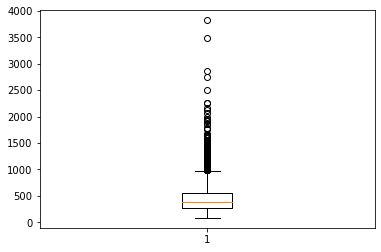

In [66]:
#Create boxplot of order time 
plt.boxplot(clean_df["order_time_seconds"])

{'whiskers': [<matplotlib.lines.Line2D at 0x2cd9b609c08>,
 'caps': [<matplotlib.lines.Line2D at 0x2cd9b377648>,
 'boxes': [<matplotlib.lines.Line2D at 0x2cd9b609c88>],
 'medians': [<matplotlib.lines.Line2D at 0x2cd9bb3db08>],
 'fliers': [<matplotlib.lines.Line2D at 0x2cd9b378b48>],
 'means': []}

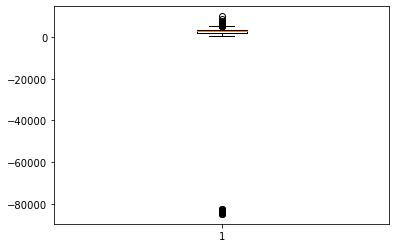

In [92]:
#plot the ordertime latency in seconds 
plt.boxplot(clean_df["dropoff_latency"])

In [ ]:
### the presence of negative values within the dropoff latency suggests that some of the 

In [10]:
#Count of all NaN in each column 
null = df.isnull().sum()
#Count all non null values 
notnull = df.count(axis=0)
#% of data that is null by column 
pct_null = (null/(null+notnull))*100
print(pct_null)

delivery_id                             0.000000
customer_id                             0.000000
jumpman_id                              0.000000
vehicle_type                            0.000000
pickup_place                            0.000000
place_category                         14.758482
item_name                              20.558248
item_quantity                          20.558248
item_category_name                     20.558248
how_long_it_took_to_order              49.222798
pickup_lat                              0.000000
pickup_lon                              0.000000
dropoff_lat                             0.000000
dropoff_lon                             0.000000
when_the_delivery_started               0.000000
when_the_Jumpman_arrived_at_pickup      9.192713
when_the_Jumpman_left_pickup            9.192713
when_the_Jumpman_arrived_at_dropoff     0.000000
dtype: float64


In [ ]:
#Formula to find distance between pickup and dropoff locations 
R = 6373.0

In [12]:
#find if there are duplicate values 
df.nunique()

delivery_id                            5214
customer_id                            3192
jumpman_id                              578
vehicle_type                              7
pickup_place                            898
place_category                           57
item_name                              2277
item_quantity                            11
item_category_name                      767
how_long_it_took_to_order              2579
pickup_lat                             1210
pickup_lon                             1179
dropoff_lat                            2841
dropoff_lon                            2839
when_the_delivery_started              5214
when_the_Jumpman_arrived_at_pickup     4719
when_the_Jumpman_left_pickup           4717
when_the_Jumpman_arrived_at_dropoff    5214
dtype: int64

In [14]:
duplicateRows = df[df.duplicated()]

In [ ]:
#Create boxplot of order duration
#Create boxplot of latency to pickup and drop off - subtract pickup time from drop off time to get latency to drop off time 
#Create heatmap of lat/long for pickups on map of NYC using leaflet.js, use counts of distinct lat and long in order to obtain intensity of different heatmap layers
#Create heatmap of lat/long for dropoffs 
#Find average distance traveled by finding the distance between pickup and dropoff locations, create a function to autofill a new column with the distance 
#Look at the number of duplicate values 
#Create a descriptive table showing data integrity values 
#Load each of these onto an index.html dashboard that can be loaded as a github page. 

In [95]:
time_df = df.dropna()

In [97]:
time_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2279 entries, 1 to 5982
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   delivery_id                          2279 non-null   int64  
 1   customer_id                          2279 non-null   int64  
 2   jumpman_id                           2279 non-null   int64  
 3   vehicle_type                         2279 non-null   object 
 4   pickup_place                         2279 non-null   object 
 5   place_category                       2279 non-null   object 
 6   item_name                            2279 non-null   object 
 7   item_quantity                        2279 non-null   float64
 8   item_category_name                   2279 non-null   object 
 9   how_long_it_took_to_order            2279 non-null   object 
 10  pickup_lat                           2279 non-null   float64
 11  pickup_lon                    

In [121]:
time_df.head(1)

,delivery_id,customer_id,jumpman_id,vehicle_type,pickup_place,place_category,item_name,item_quantity,item_category_name,how_long_it_took_to_order,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,when_the_delivery_started,when_the_Jumpman_arrived_at_pickup,when_the_Jumpman_left_pickup,when_the_Jumpman_arrived_at_dropoff,dropoff_latency,dropoff_latency_minutes
1,1377056,64452,104533,bicycle,Prince Street Pizza,Pizza,Neapolitan Rice Balls,3.0,Munchables,0 days 00:25:09.107093,40.72308,-73.994615,40.719722,-73.991858,2014-10-16 21:58:58.654910,2014-10-16 22:26:02.120931,2014-10-16 22:48:23.091253,2014-10-16 22:59:22.948873,0 days 01:00:24.293963,60.404899


In [99]:
#convert time columns to datetime objects
time_df["when_the_delivery_started"] = pd.to_datetime(time_df["when_the_delivery_started"])
time_df["when_the_Jumpman_arrived_at_pickup"] = pd.to_datetime(time_df["when_the_Jumpman_arrived_at_pickup"])
time_df["when_the_Jumpman_left_pickup"] = pd.to_datetime(time_df["when_the_Jumpman_left_pickup"])
time_df["when_the_Jumpman_arrived_at_dropoff"] = pd.to_datetime(time_df["when_the_Jumpman_arrived_at_dropoff"])

In [101]:
#convert order time to timedelta object 
time_df["how_long_it_took_to_order"] = pd.to_timedelta(time_df["how_long_it_took_to_order"])

In [123]:
#convert timedelta object to minutes 
time_df["how_long_it_took_to_order"] = time_df["how_long_it_took_to_order"] / np.timedelta64(1, 'm')

In [113]:
#Create column of dropoff latency 
time_df["dropoff_latency"] = time_df["when_the_Jumpman_arrived_at_dropoff"] - time_df["when_the_delivery_started"]

In [120]:
#convert time delta object to minutes 
time_df["dropoff_latency_minutes"] = time_df["dropoff_latency"] / np.timedelta64(1, 'm')

In [154]:
#Create column for prep latency
time_df["prep_latency"] = time_df["when_the_Jumpman_left_pickup"] - time_df["when_the_Jumpman_arrived_at_pickup"]
time_df["prep_latency"] = time_df["prep_latency"] / np.timedelta64(1, 'm')
#Create column for transit time
time_df["transit_time"] = time_df["when_the_Jumpman_arrived_at_dropoff"] - time_df["when_the_Jumpman_left_pickup"]
#Convert to minutes
time_df["transit_time"] = time_df["transit_time"] / np.timedelta64(1, 'm') 

{'whiskers': [<matplotlib.lines.Line2D at 0x2cd9e3c0b48>,
 'caps': [<matplotlib.lines.Line2D at 0x2cd9d8fd988>,
 'boxes': [<matplotlib.lines.Line2D at 0x2cd9e1dfe48>],
 'medians': [<matplotlib.lines.Line2D at 0x2cd9c41b9c8>],
 'fliers': [<matplotlib.lines.Line2D at 0x2cd9e449dc8>],
 'means': []}

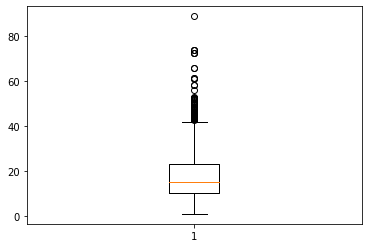

In [155]:
plt.boxplot(time_df["prep_latency"])

{'whiskers': [<matplotlib.lines.Line2D at 0x2cd9bee0b48>,
 'caps': [<matplotlib.lines.Line2D at 0x2cd9c489b88>,
 'boxes': [<matplotlib.lines.Line2D at 0x2cd9d53ec48>],
 'medians': [<matplotlib.lines.Line2D at 0x2cd9e31ab48>],
 'fliers': [<matplotlib.lines.Line2D at 0x2cd9bfb8bc8>],
 'means': []}

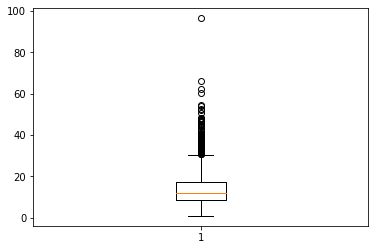

In [156]:
plt.boxplot(time_df["transit_time"])

{'whiskers': [<matplotlib.lines.Line2D at 0x2cd9d5a8888>,
 'caps': [<matplotlib.lines.Line2D at 0x2cd9da88348>,
 'boxes': [<matplotlib.lines.Line2D at 0x2cd9b8afd08>],
 'medians': [<matplotlib.lines.Line2D at 0x2cd9769c208>],
 'fliers': [<matplotlib.lines.Line2D at 0x2cd9c325088>],
 'means': []}

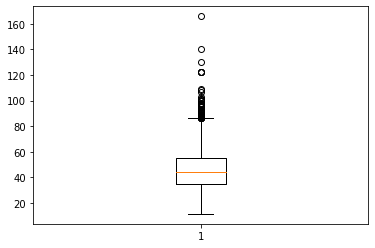

In [124]:
#boxplot of dropoff_latency in hours 
plt.boxplot(time_df["dropoff_latency_minutes"])

{'whiskers': [<matplotlib.lines.Line2D at 0x2cd9bb06bc8>,
 'caps': [<matplotlib.lines.Line2D at 0x2cd9da013c8>,
 'boxes': [<matplotlib.lines.Line2D at 0x2cd9b6f3c88>],
 'medians': [<matplotlib.lines.Line2D at 0x2cd972d7248>],
 'fliers': [<matplotlib.lines.Line2D at 0x2cd9a580488>],
 'means': []}

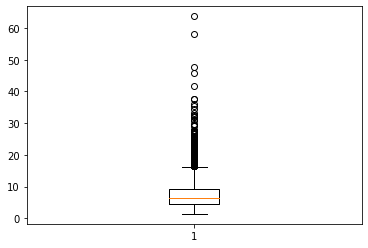

In [125]:
#length to order in hours 
plt.boxplot(time_df["how_long_it_took_to_order"])

In [133]:
time_df["vehicle_type"].unique()

array(['bicycle', 'car', 'truck', 'scooter', 'walker', 'van',
       'motorcycle'], dtype=object)

In [134]:
vehicle_type_dict = {
    "Bicycle" : time_df[time_df["vehicle_type"] == "bicycle"].shape[0],
    "Car" : time_df[time_df["vehicle_type"] == "car"].shape[0],
    "Truck" : time_df[time_df["vehicle_type"] == "truck"].shape[0],
    "Scooter" : time_df[time_df["vehicle_type"] == "scooter"].shape[0],
    "Walker" : time_df[time_df["vehicle_type"] == "walker"].shape[0],
    "Van" : time_df[time_df["vehicle_type"] == "van"].shape[0],
    "Motorcycle" : time_df[time_df["vehicle_type"] == "motorcycle"].shape[0]
}

In [136]:
vehicle_type = {
    "Type" : ["Bicycle", "Car", "Truck", "Scooter", "Walker", "Van", "Motorcycle"],
    "Count" : [time_df[time_df["vehicle_type"] == "bicycle"].shape[0], time_df[time_df["vehicle_type"] == "car"].shape[0], time_df[time_df["vehicle_type"] == "truck"].shape[0], time_df[time_df["vehicle_type"] == "scooter"].shape[0], time_df[time_df["vehicle_type"] == "walker"].shape[0], time_df[time_df["vehicle_type"] == "van"].shape[0], time_df[time_df["vehicle_type"] == "motorcycle"].shape[0]]
}

In [137]:
vehicle_type

{'Type': ['Bicycle', 'Car', 'Truck', 'Scooter', 'Walker', 'Van', 'Motorcycle'],
 'Count': [1640, 478, 22, 20, 87, 25, 7]}

<BarContainer object of 7 artists>

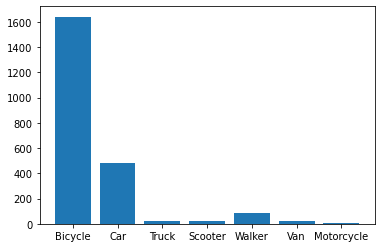

In [140]:
plt.bar(vehicle_type["Type"], vehicle_type["Count"])

In [143]:
def haversine_distance(lat1, lon1, lat2, lon2):
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 2)

In [144]:
distances_km = []

In [146]:
for row in time_df.itertuples(index=False):
    distances_km.append(
        haversine_distance(row.pickup_lat, row.pickup_lon, row.dropoff_lat, row.dropoff_lon)
    )

In [148]:
time_df["distance_km"] = distances_km

In [152]:
time_df["distance_miles"] = time_df["distance_km"] * 0.62137

In [153]:
time_df["distance_miles"].describe()

count    2279.000000
mean        1.208048
std         0.964598
min         0.018641
25%         0.577874
50%         0.925841
75%         1.503715
max         7.475081
Name: distance_miles, dtype: float64

In [ ]:
{'Type': ['Bicycle', 'Car', 'Truck', 'Scooter', 'Walker', 'Van', 'Motorcycle']

In [177]:
#Retrieve distance traveled by each vehicle type 
bicycle = time_df.loc[time_df["vehicle_type"] == "bicycle"]
bicycle_distance = bicycle["distance_miles"].tolist()
car = time_df.loc[time_df["vehicle_type"] == "car"]
car_distance = car["distance_miles"].tolist()
truck = time_df.loc[time_df["vehicle_type"] == 'truck']
truck_distance = truck["distance_miles"].tolist()
scooter = time_df.loc[time_df["vehicle_type"] == 'scooter']
scooter_distance = scooter["distance_miles"].tolist()
walker = time_df.loc[time_df['vehicle_type'] == "walker"]
walker_distance = walker["distance_miles"].tolist()
van = time_df.loc[time_df["vehicle_type"] == 'van']
van_distance = van["distance_miles"].tolist()
motorcycle = time_df.loc[time_df["vehicle_type"]=='motorcycle']
motorcycle_distance = motorcycle["distance_miles"].tolist()
data = [bicycle_distance, car_distance, truck_distance, scooter_distance, walker_distance, van_distance, motorcycle_distance]

{'whiskers': [<matplotlib.lines.Line2D at 0x2cd9b959988>,
 'caps': [<matplotlib.lines.Line2D at 0x2cd9c33ad88>,
 'boxes': [<matplotlib.lines.Line2D at 0x2cd9c3193c8>,
 'medians': [<matplotlib.lines.Line2D at 0x2cd9de55d88>,
 'fliers': [<matplotlib.lines.Line2D at 0x2cd9d5c4108>,
 'means': []}

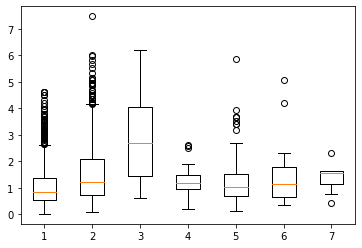

In [178]:
plt.boxplot(data)

In [258]:
top_ten = pd.DataFrame(time_df["pickup_place"].value_counts().head(10))

In [233]:
top_ten.reset_index()
top_ten.rename(columns={"index" : "pickup_place", "pickup_place" : "order_count"}, inplace=True)

In [254]:
top_ten.insert(0, "ID", range(0, len(top_ten)))

In [262]:
top_ten_names = top_ten.index.tolist()

In [301]:
#Find dropoff latency for the top 10 restaurants
avg_dropoff_latency_dict = {
    "Name" : top_ten_names
}
avg_dropoff_latency = []

In [302]:
for name in top_ten_names:
    temp = time_df.loc[time_df["pickup_place"] == name]["dropoff_latency_minutes"].mean()
    avg_dropoff_latency.append(temp)
avg_dropoff_latency_dict["time"] = avg_dropoff_latency

In [304]:
avg_dropoff_latency_dict

{'Name': ['The Meatball Shop',
  'Blue Ribbon Sushi',
  'sweetgreen',
  'RedFarm Broadway',
  'Parm',
  'TAO',
  'RedFarm Hudson',
  'Sushi of Gari 46',
  'Han Dynasty',
  'Rubirosa'],
 'time': [38.6594872530754,
  51.25306869905914,
  47.789403787301595,
  49.818507510112354,
  44.858544931050226,
  52.91776119731183,
  40.9183275302469,
  56.49553124166667,
  47.43959289833333,
  54.1444358890071]}

In [206]:
nyc_coords = (40.7831, -73.9712)

Text(0.5, 1.0, 'Top Ten Pickup Places NYC')

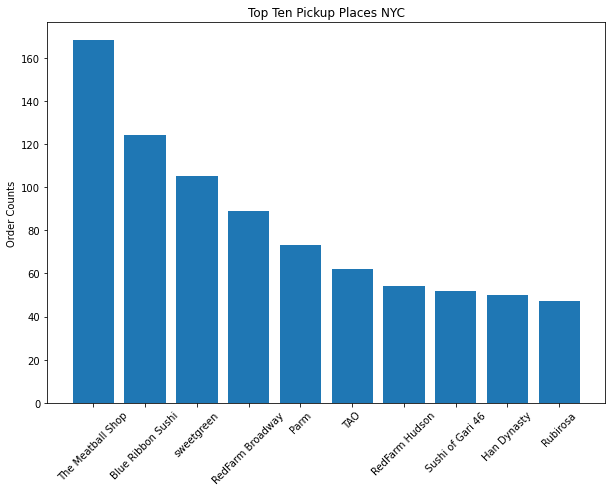

In [267]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)

brp = ax.bar(x=top_ten_names, height=top_ten["pickup_place"])
plt.xticks(rotation=45)
plt.ylabel("Order Counts")
plt.title("Top Ten Pickup Places NYC")

Text(0.5, 1.0, 'Fulfillment Time for Top Ten Restaurants')

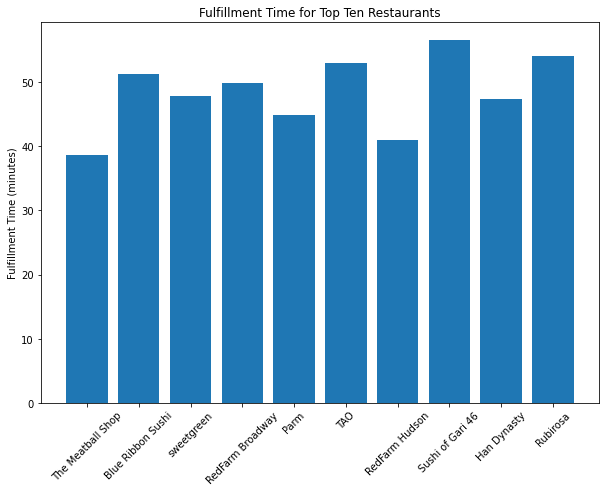

In [305]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)

brp = ax.bar(x=avg_dropoff_latency_dict["Name"], height=avg_dropoff_latency_dict["time"])
plt.xticks(rotation=45)
plt.ylabel("Fulfillment Time (minutes)")
plt.title("Fulfillment Time for Top Ten Restaurants")

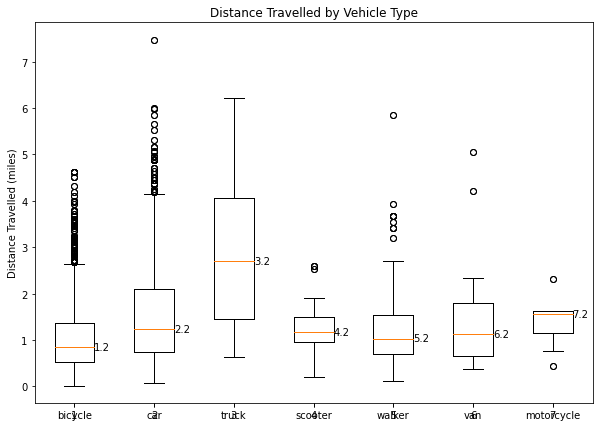

In [219]:
#boxplot of distance travelled by vehicle type 
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)

bp = ax.boxplot(data)
ax.set_ylabel("Distance Travelled (miles)")
ax.set_xticklabels(["bicycle", "car", "truck", "scooter", "walker", "van", "motorcycle"])
plt.title("Distance Travelled by Vehicle Type")

vtdist_bpdict = boxplot(data)

for line in vtdist_bpdict['medians']:
    x, y = line.get_xydata()[1]
    text(x, y, '%.1f' % x, 
        verticalalignment='center')

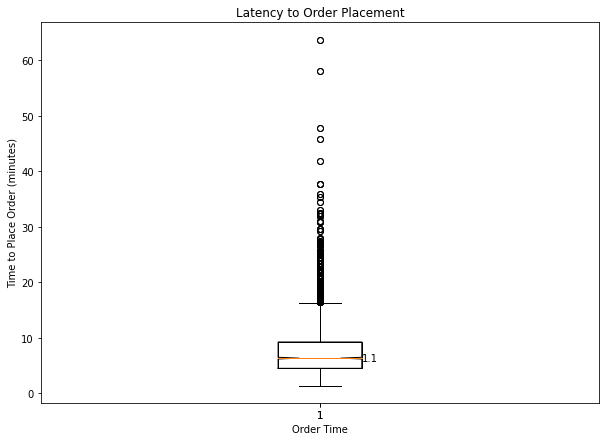

In [307]:
#Create boxplot of order duration
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)

bp = ax.boxplot(time_df["how_long_it_took_to_order"], notch=True)
ax.set_ylabel("Time to Place Order (minutes)")
ax.set_xlabel("Order Time")
plt.title("Latency to Order Placement")

od_bpdict = boxplot(time_df["how_long_it_took_to_order"])

for line in od_bpdict['medians']:
    x, y = line.get_xydata()[1]
    text(x, y, '%.1f' % x,
        verticalalignment='center')

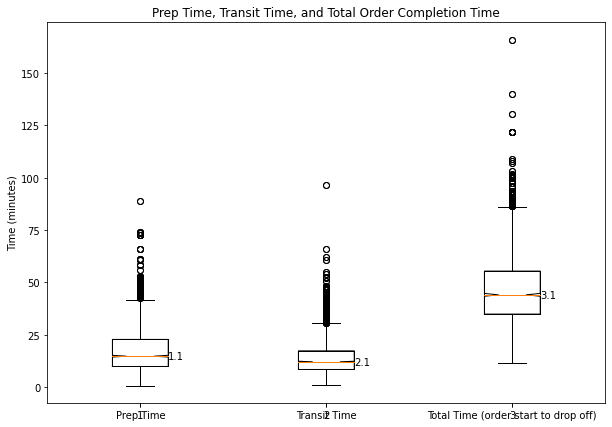

In [221]:
#Create boxplot of latency to pickup and drop off - subtract pickup time from drop off time to get latency to drop off time 
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)

bp = ax.boxplot([time_df["prep_latency"], time_df["transit_time"], time_df["dropoff_latency_minutes"]], notch=True)
ax.set_ylabel("Time (minutes)")
ax.set_xticklabels(["Prep Time", "Transit Time", "Total Time (order start to drop off)"])
plt.title("Prep Time, Transit Time, and Total Order Completion Time")

lt_bpdict = boxplot([time_df["prep_latency"], time_df["transit_time"], time_df["dropoff_latency_minutes"]])

for line in lt_bpdict['medians']:
    x, y = line.get_xydata()[1]
    text(x, y, '%.1f' % x,
        verticalalignment='center')

In [211]:
#Create heatmap of lat/long for pickups on map of NYC using leaflet.js, use counts of distinct lat and long in order to obtain intensity of different heatmap layers
gmaps.configure(api_key=api_key)
fig = gmaps.figure(center=nyc_coords, zoom_level=11)
fig.add_layer(gmaps.heatmap_layer(time_df[["pickup_lat", "pickup_lon"]]))
fig

Figure(layout=FigureLayout(height='420px'))

In [212]:
fig = gmaps.figure(center=nyc_coords, zoom_level=11)
fig.add_layer(gmaps.heatmap_layer(time_df[["dropoff_lat", "dropoff_lon"]]))
fig

Figure(layout=FigureLayout(height='420px'))

In [ ]:
#Find average distance traveled by finding the distance between pickup and dropoff locations, create a function to autofill a new column with the distance

In [ ]:
#Create boxplot of order duration
#Create boxplot of latency to pickup and drop off - subtract pickup time from drop off time to get latency to drop off time 
#Create heatmap of lat/long for pickups on map of NYC using leaflet.js, use counts of distinct lat and long in order to obtain intensity of different heatmap layers
#Create heatmap of lat/long for dropoffs 
#Find average distance traveled by finding the distance between pickup and dropoff locations, create a function to autofill a new column with the distance 
#Look at the number of duplicate values 
#Create a descriptive table showing data integrity values 
#Load each of these onto an index.html dashboard that can be loaded as a github page. 